In [1]:
import cv2 as cv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def disp_img(img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

In [46]:
mpl.rcParams['figure.dpi']= 180

In [112]:
img = cv.imread('01.png')

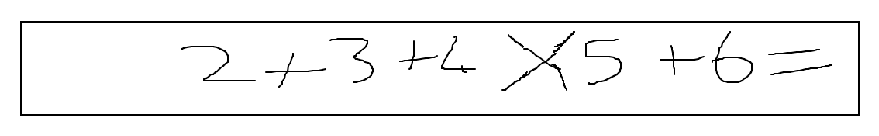

In [113]:
disp_img(img)

In [114]:
img.shape

(120, 1080, 3)

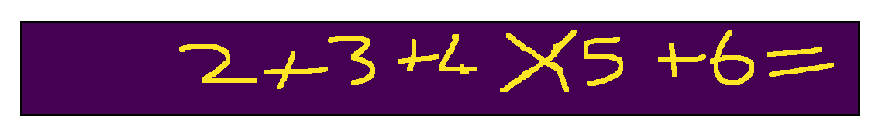

In [115]:
gray = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (5, 5), 5)
thresh = cv.adaptiveThreshold(blurred, 255, 0, 1, 115, 1)

disp_img(thresh)

In [116]:
kernel = np.ones((3,3),np.uint8)
dilation = cv.dilate(thresh,kernel,iterations = 0)

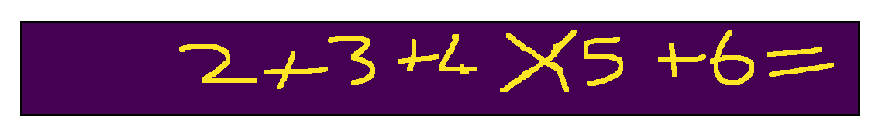

In [117]:
disp_img(dilation)

In [118]:
_, contours, hierarchy = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])
rects = [cv.boundingRect(ctr) for ctr in contours]

In [119]:
rects

[(204, 30, 101, 50),
 (313, 39, 83, 49),
 (396, 20, 61, 62),
 (486, 23, 54, 42),
 (540, 17, 49, 52),
 (618, 11, 99, 81),
 (726, 21, 51, 63),
 (822, 29, 62, 43),
 (889, 11, 57, 71),
 (962, 34, 71, 12),
 (965, 54, 84, 18)]

In [120]:
new_rects = []
pad = 2
for rect in rects:
    if rect[2]/rect[3] > 5:
        temp = []
        temp.append(rect[0]-pad)
        temp.append(rect[1]-int(rect[2]))
        temp.append(rect[2]+pad)
        temp.append(rect[3]+int(2 * rect[2]))
        new_rects.append(tuple(temp))
    else:
        new_rects.append(rect)

In [121]:
new_rects

[(204, 30, 101, 50),
 (313, 39, 83, 49),
 (396, 20, 61, 62),
 (486, 23, 54, 42),
 (540, 17, 49, 52),
 (618, 11, 99, 81),
 (726, 21, 51, 63),
 (822, 29, 62, 43),
 (889, 11, 57, 71),
 (960, -37, 73, 154),
 (965, 54, 84, 18)]

In [122]:
def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

def intersection(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0: return () # or (0,0,0,0) ?
    return (x, y, w, h)

In [123]:
def rect_area(rect):
    try:
        return rect[2] * rect[3]
    except IndexError:
        return 0

In [124]:
from itertools import combinations
windows = list(zip(new_rects, new_rects[1:], new_rects[2:]))
final_rects = deepcopy(new_rects)
for window in windows:
    for combination in combinations(window, 2):
        combination = list(combination)
        common = intersection(combination[0], combination[1])
        area_common = rect_area(common)
        area1 = rect_area(combination[0])
        area2 = rect_area(combination[1])
        combination = sorted(combination, key=lambda x: rect_area(x), reverse=True)
        try:
            if area_common == area1 or area_common == area2:
                final_rects.remove(combination[-1])
            if area_common > area1/2 or area_common > area2/2:
                final_rects.remove(combination[-1])
        except ValueError:
            pass

In [138]:
output_img = img.copy()
extracted_rects = []
pad = 1

for (x, y, w, h) in final_rects:
    x = max(1, x)
    y = max(1, y)
    w = min(img.shape[1]-1, w)
    h = min(img.shape[0]-1, h)
    extracted_rects.append(dilation.copy()[y-pad: y + h+pad, x-pad: x + w+pad])
    rect = cv.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 3)

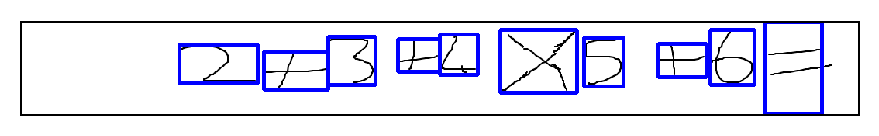

In [139]:
disp_img(output_img)

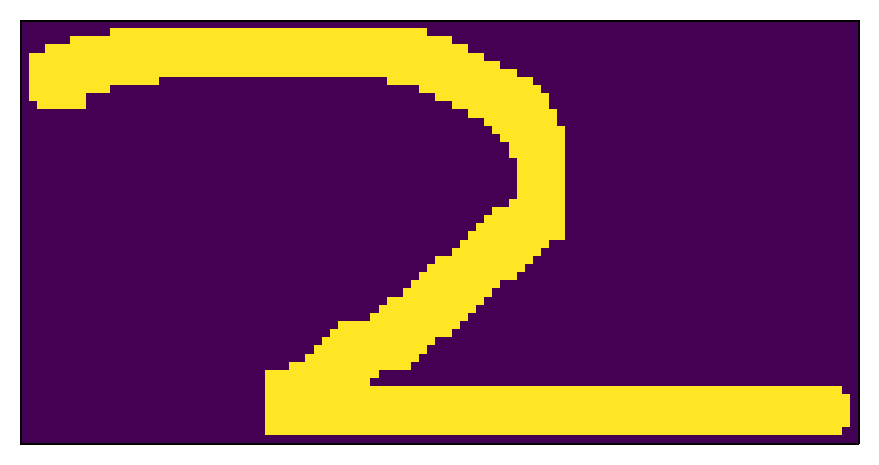

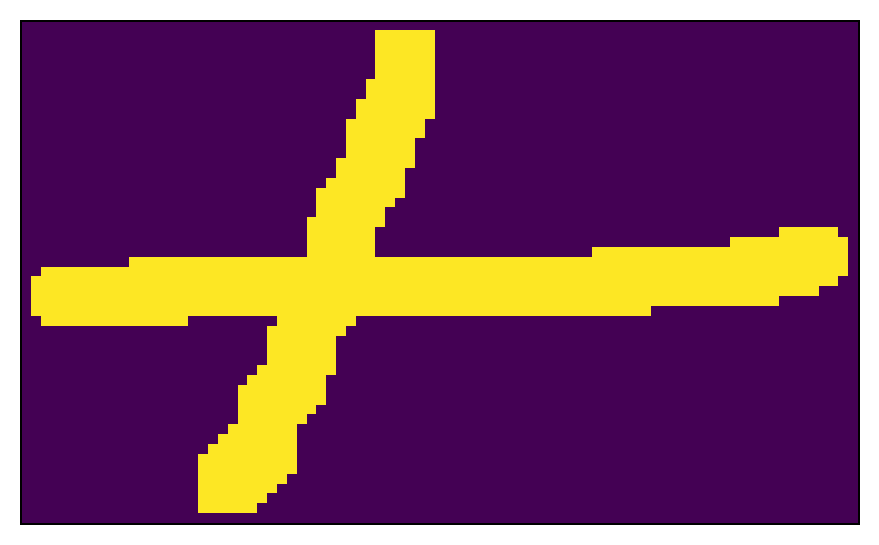

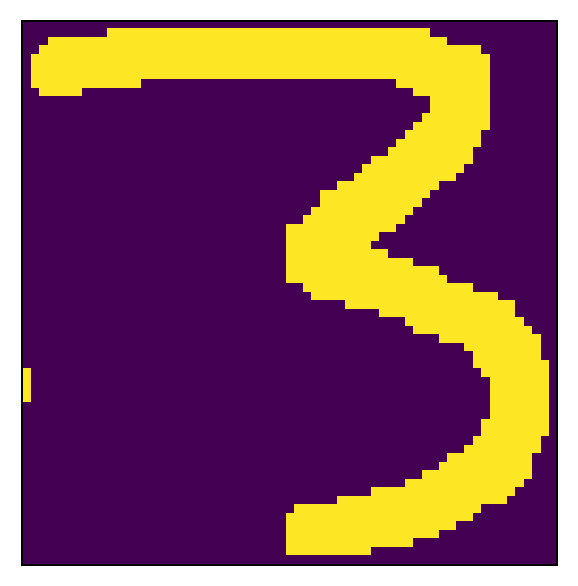

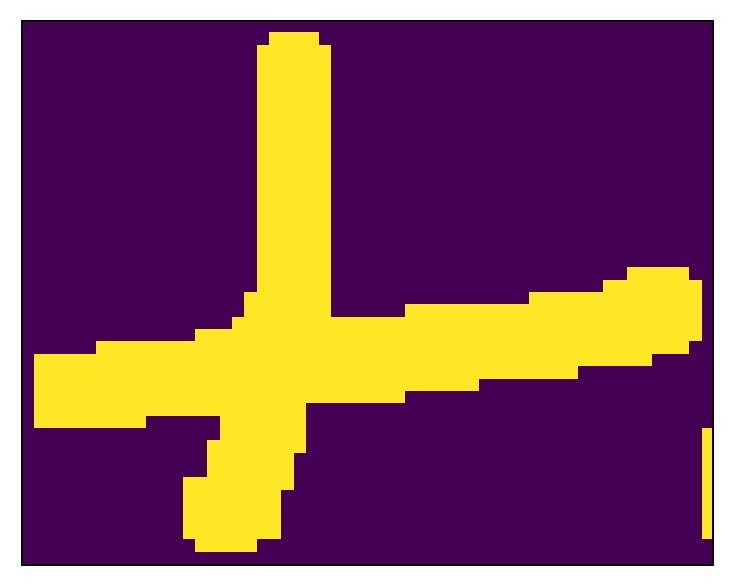

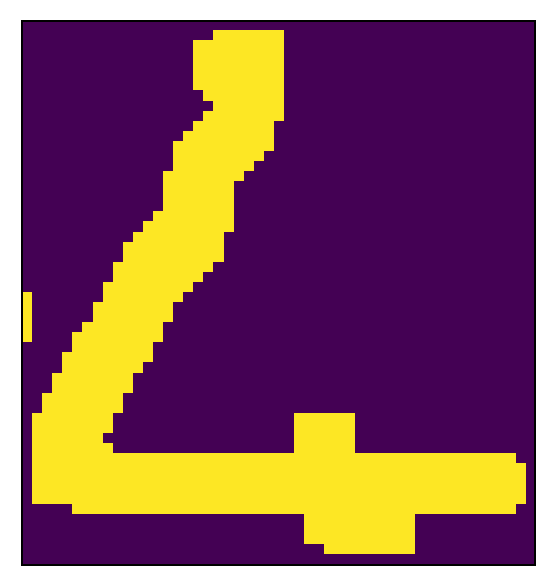

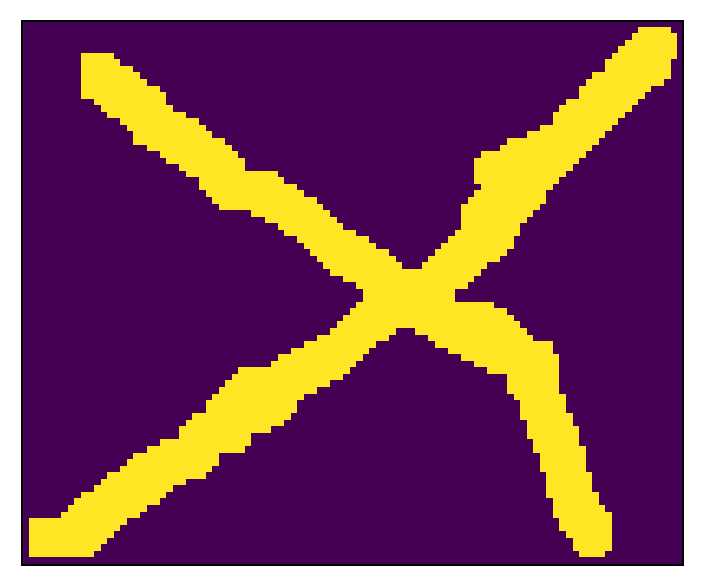

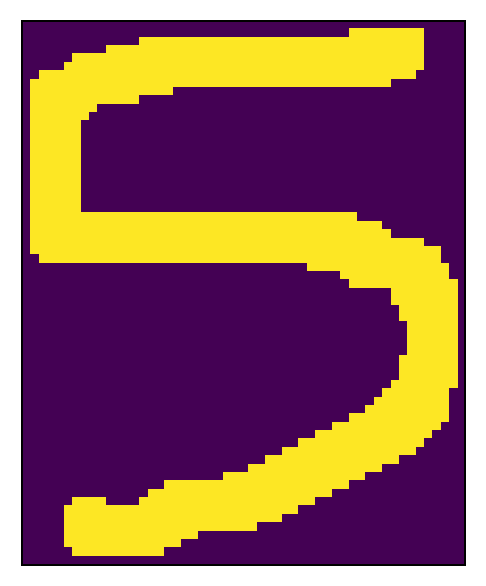

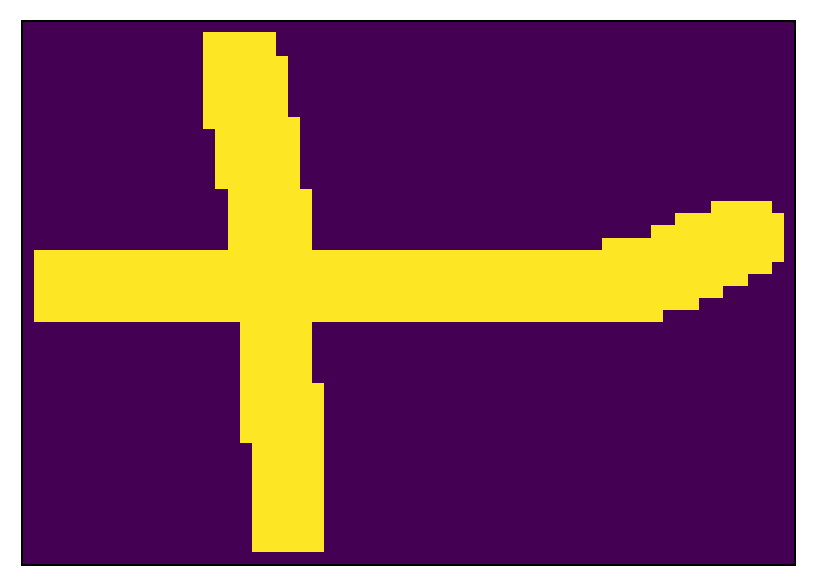

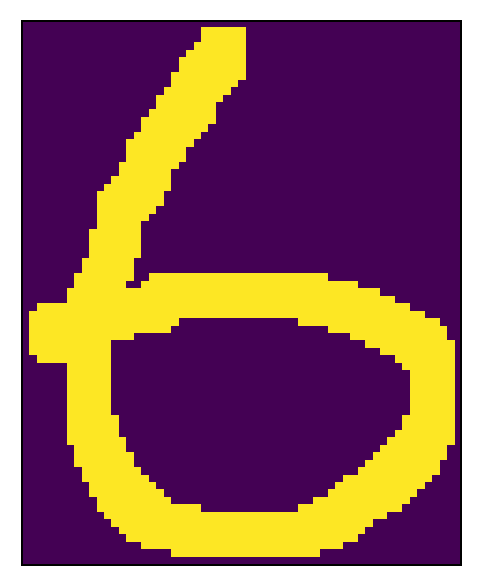

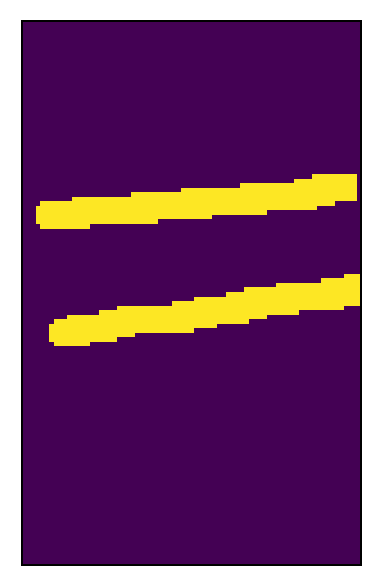

In [140]:
for i in extracted_rects:
    disp_img(i)

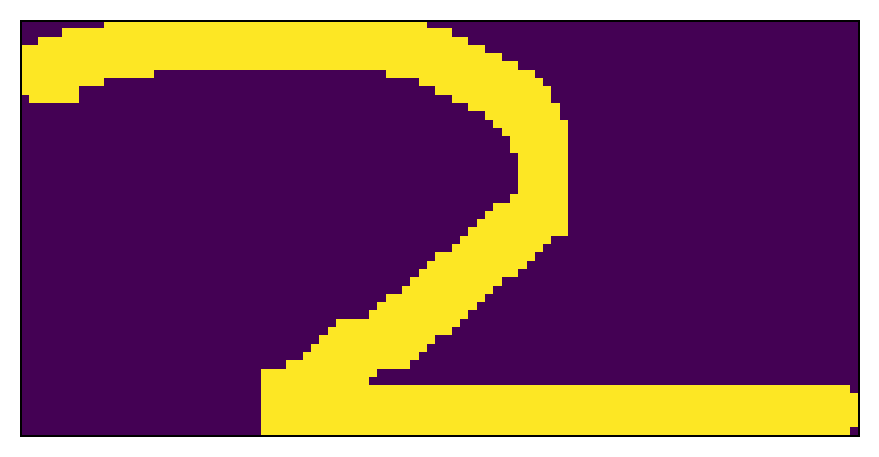

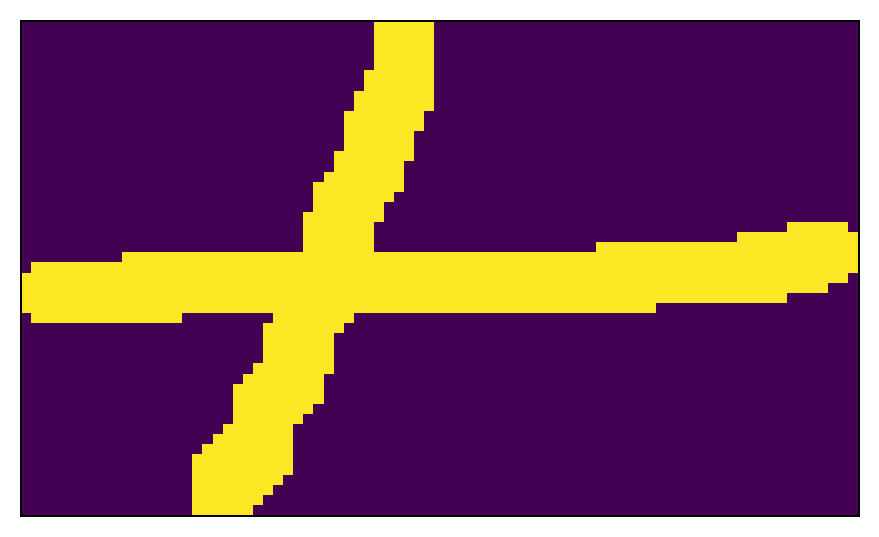

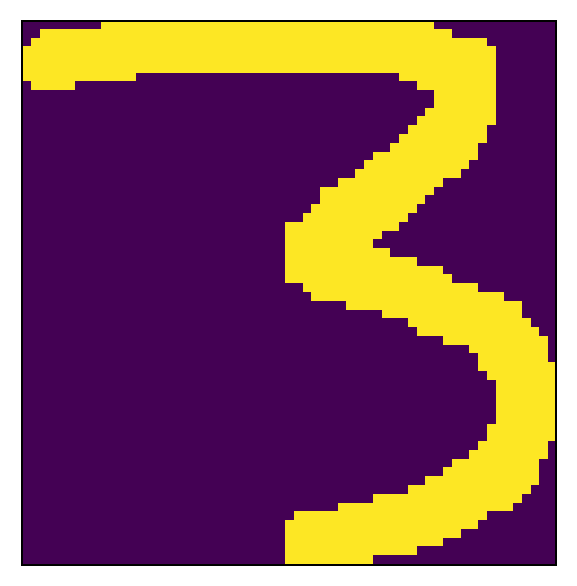

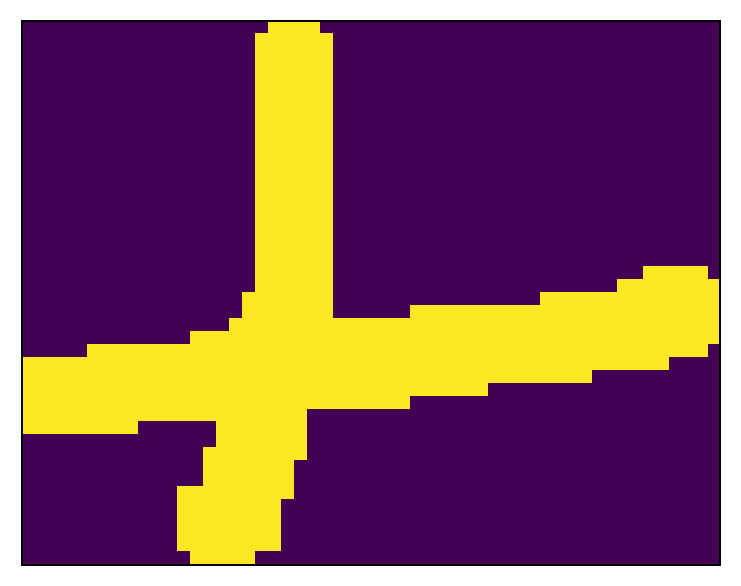

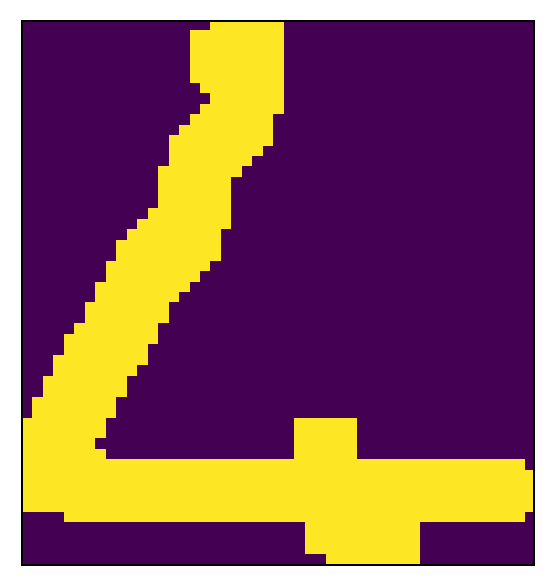

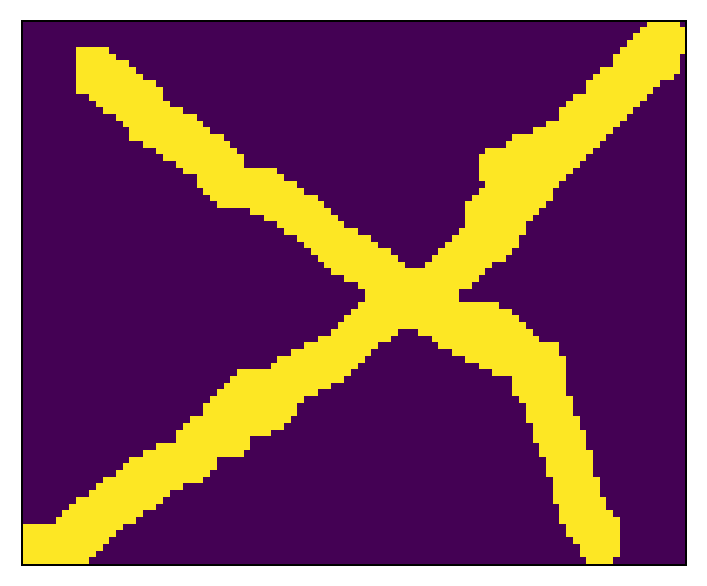

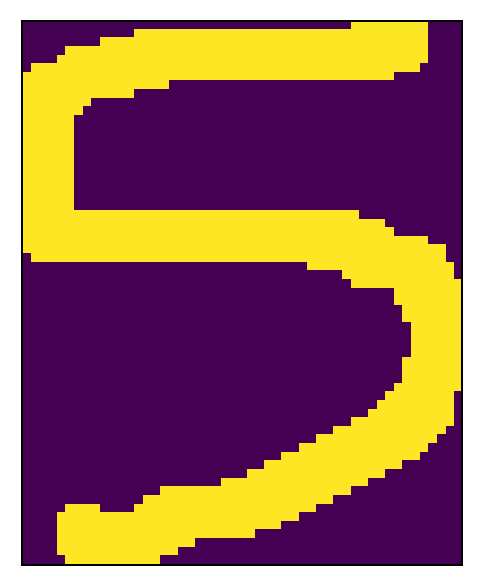

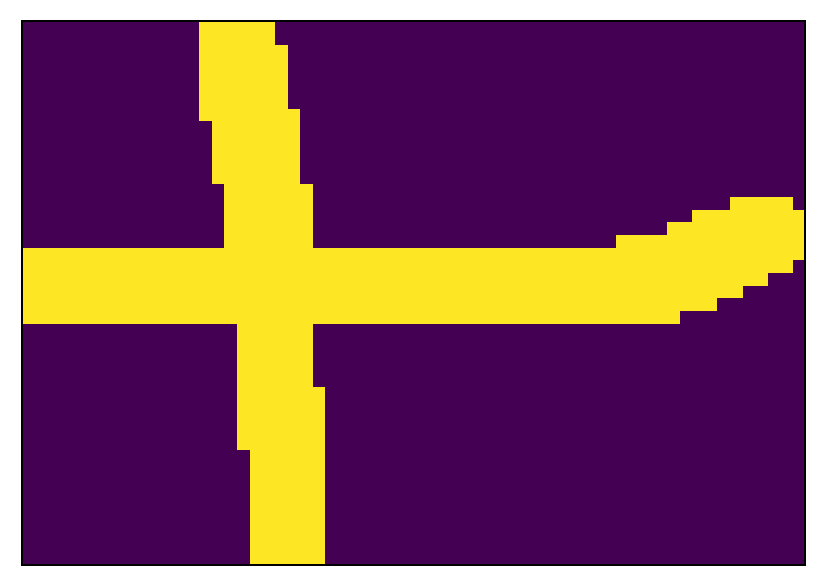

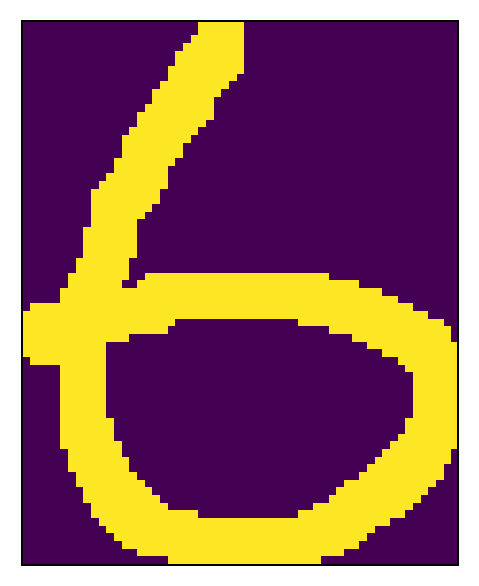

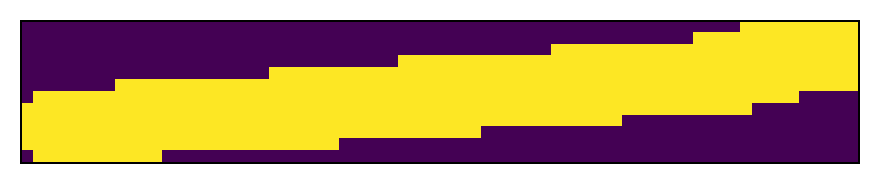

In [141]:
final_extracted_rects = []
pad = 0

for i in extracted_rects:
    
    _, cnts, hierarchy = cv.findContours(i, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    for c in cnts:
        (x, y, w, h) = cv.boundingRect(c)
        boxes = [x,y, x+w,y+h]

    boxes = np.asarray(boxes)
    left = np.min(boxes[0])
    top = np.min(boxes[1])
    right = np.max(boxes[2])
    bottom = np.max(boxes[3])
    
    final_extracted_rects.append(i.copy()[top-pad: bottom+pad, left-pad: right+pad])

for i in final_extracted_rects:
    disp_img(i)

In [142]:
square_padded_digits = []
b_pad = 1
for i in final_extracted_rects:
    old_size = i.shape
    desired_size = max(i.shape)

    delta_w = desired_size - old_size[1]
    delta_h = desired_size - old_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    square_padded_digits.append(cv.copyMakeBorder(i, top+b_pad, bottom+b_pad, left+b_pad, right+b_pad, borderType= cv.BORDER_CONSTANT, value=[0,0,0]))

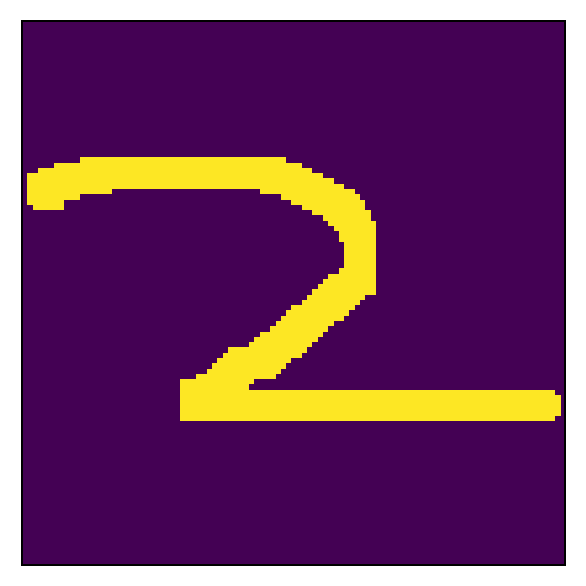

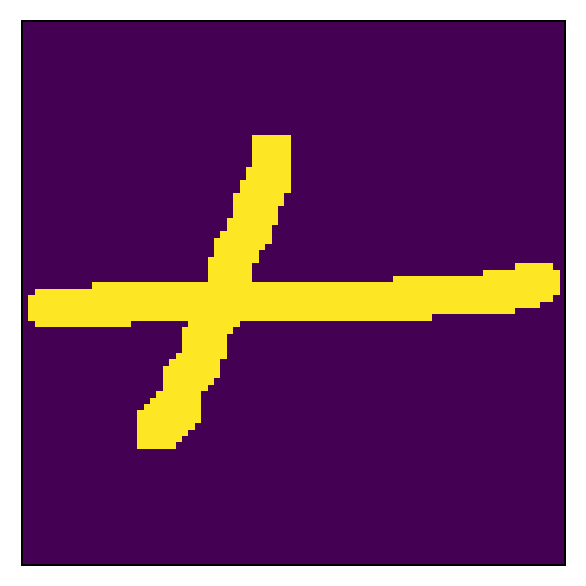

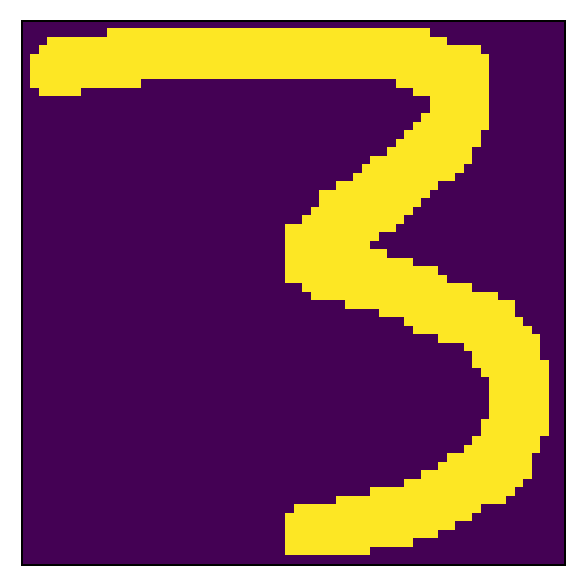

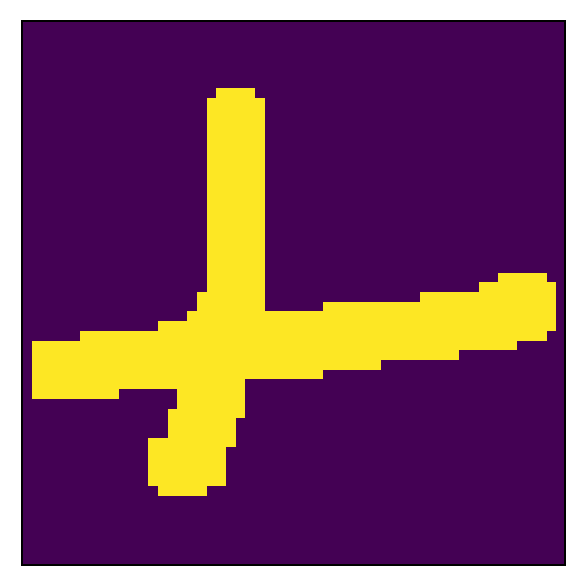

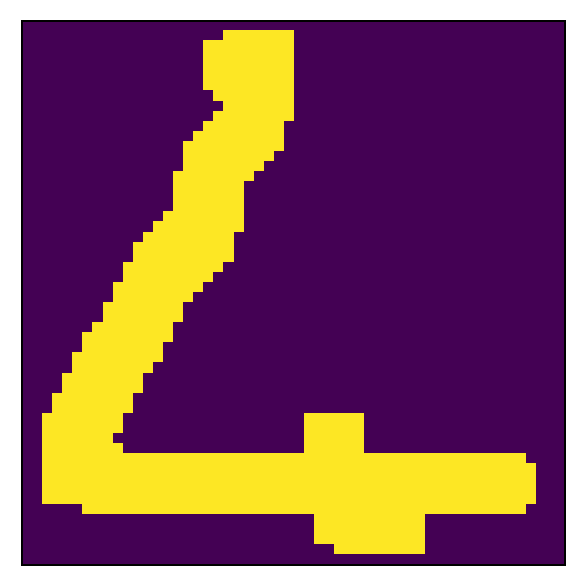

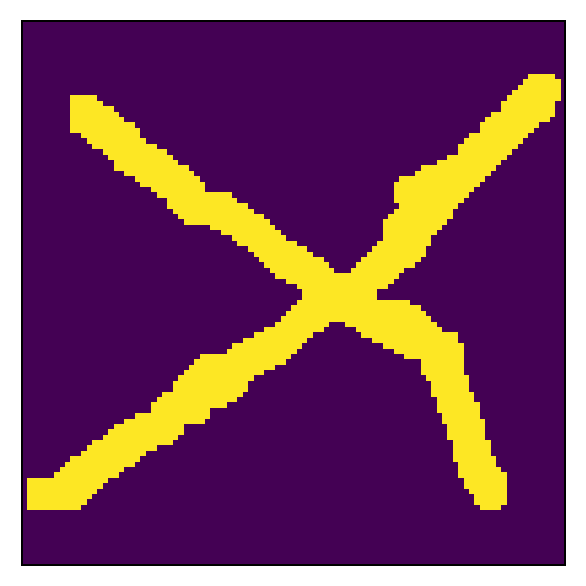

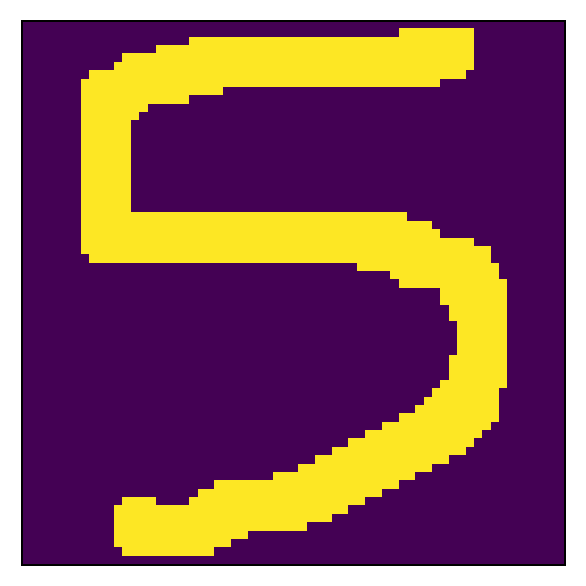

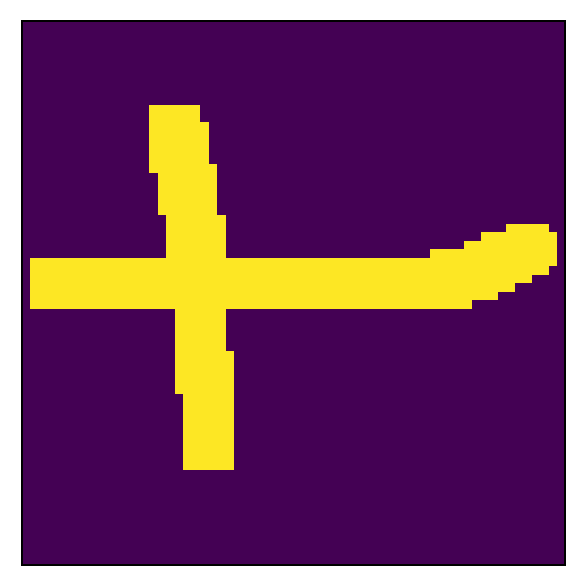

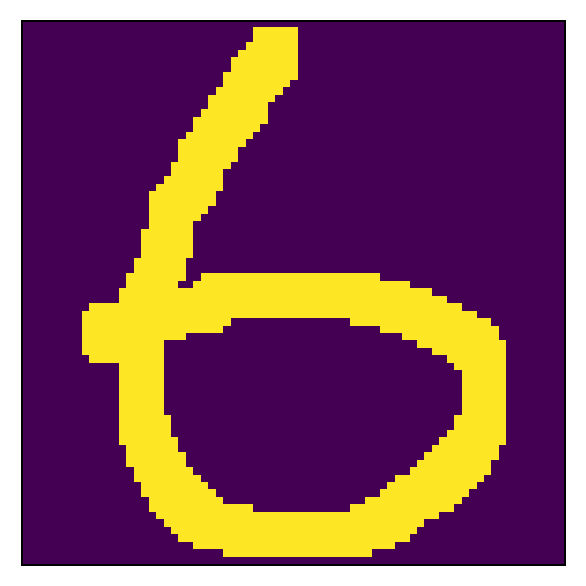

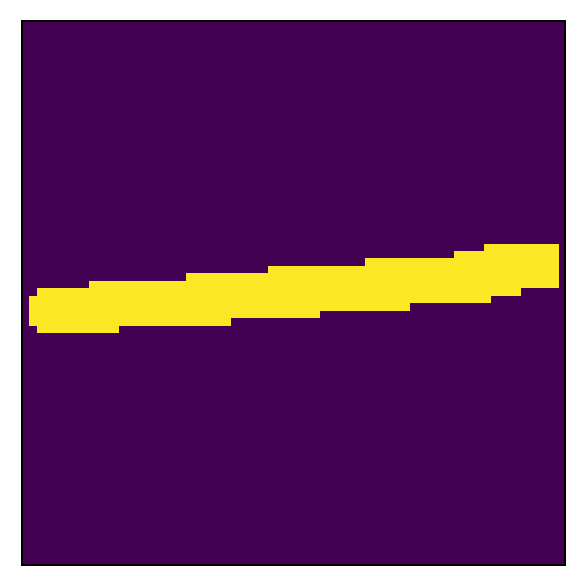

In [143]:
for i in square_padded_digits:
    disp_img(i)

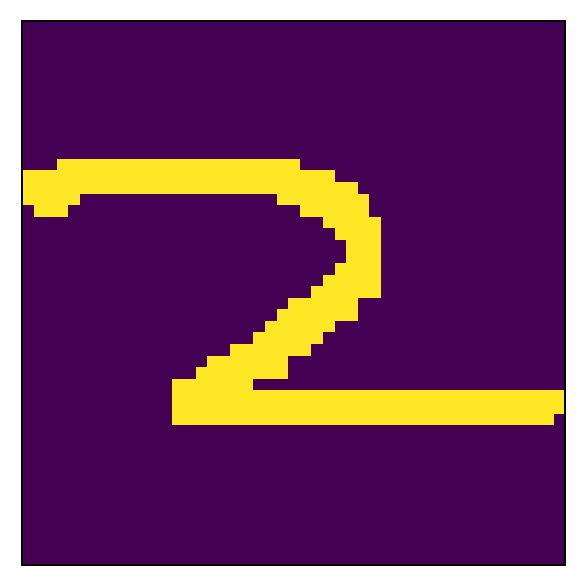

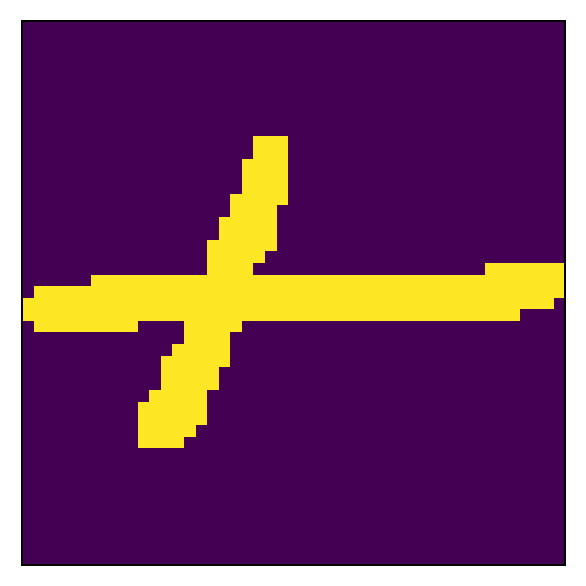

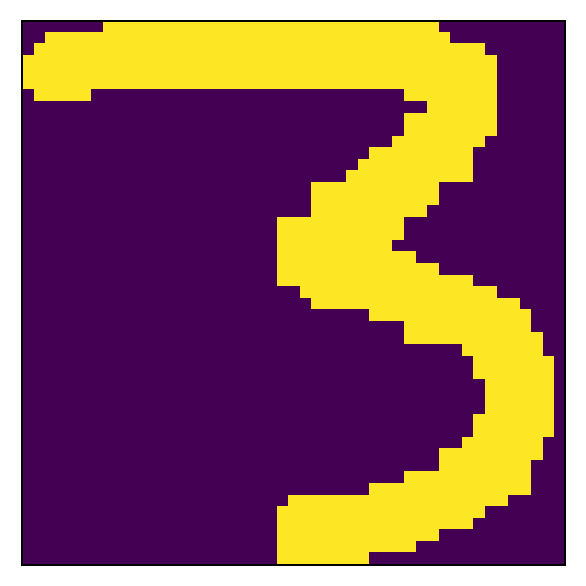

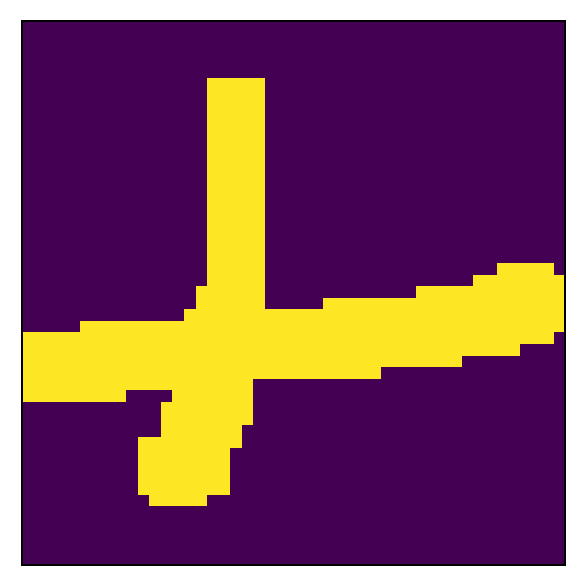

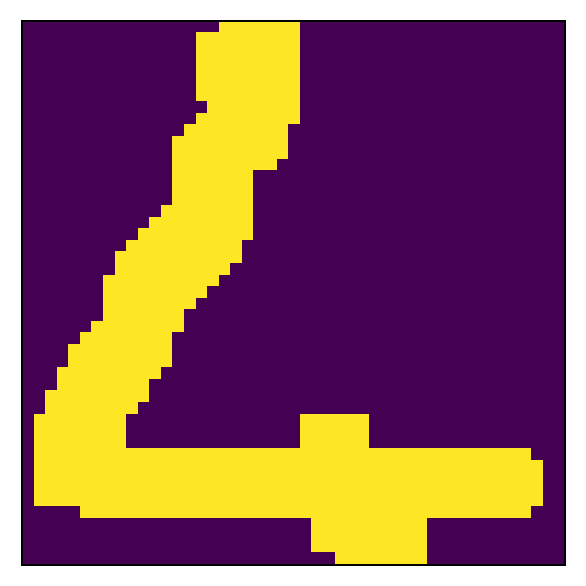

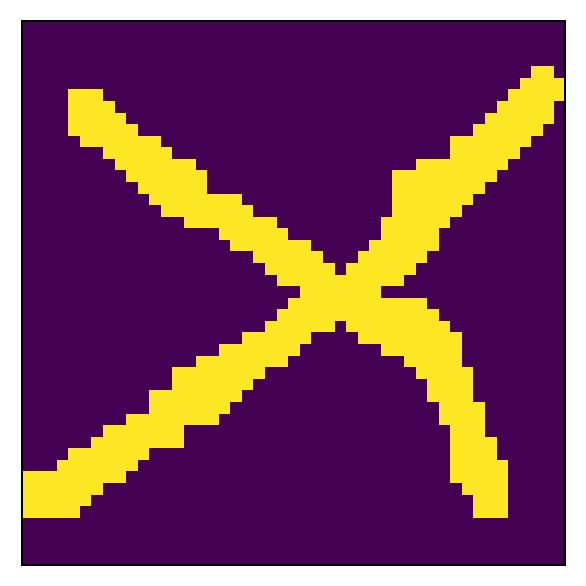

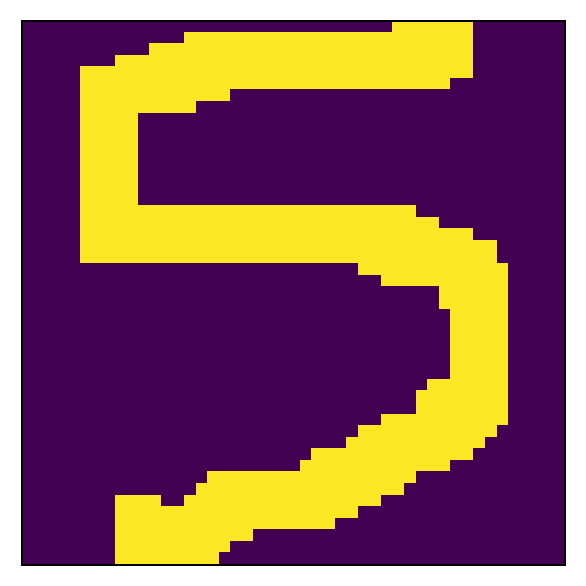

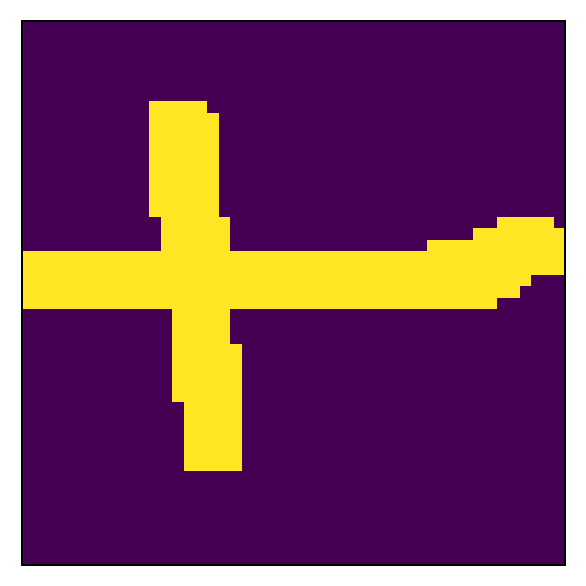

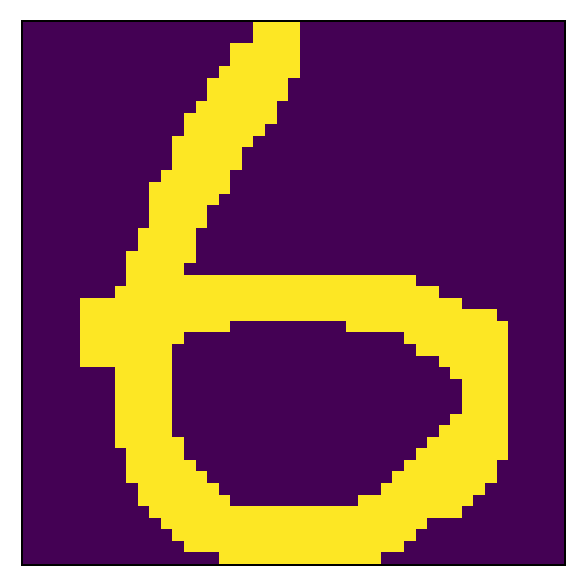

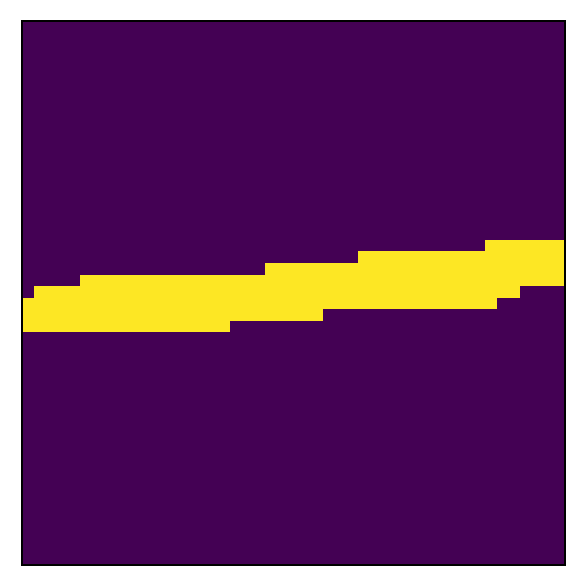

In [144]:
final_symbols = []
for i in square_padded_digits:
#     i = cv.dilate(i,kernel,iterations = 1)
    resized = cv.resize(i, (47, 47))
    _, segmented_thresh = cv.threshold(resized,0,1,cv.THRESH_BINARY)
    final_symbols.append(segmented_thresh)
#     closing = cv.morphologyEx(segmented_thresh, cv.MORPH_CLOSE, kernel)
    disp_img(segmented_thresh)

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6427866597231198230
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1432249958
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8214470614588555868
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

In [39]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [1]:
from keras.models import model_from_json

with open('model.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('model.h5')

Using TensorFlow backend.


In [45]:
del model

NameError: name 'model' is not defined

In [4]:
model.save('saved_model.h5')

In [42]:
from keras.models import load_model
model = load_model('saved_model.h5')

In [2]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'x', 'div', '=', '(', ')']

In [27]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', '/', '=']

In [28]:
final_symbols = np.asarray(final_symbols).reshape(-1, 47, 47, 1)

In [29]:
final_symbols.shape

(6, 47, 47, 1)

In [48]:
model_predictions = model.predict_classes(final_symbols)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_7_4/convolution}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_7_4/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_7_4/kernel/read)]]
	 [[{{node dense_6_4/Softmax/_409}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_127_dense_6_4/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [213]:
predicted_symbols = [labels[i] for i in model_predictions]

In [214]:
predicted_symbols

['7', '3', '7', '3', '7', '3']

In [215]:
if predicted_symbols[-1] == '=':
    predicted_symbols.pop()

answer = eval(''.join(predicted_symbols))
print(answer)

737373
